# Vector Representations
## *Data Science Unit 4 Sprint 2 Assignment 2*

In [1]:
import re
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy
from bs4 import BeautifulSoup
import squarify
import matplotlib
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

## 2) Use Spacy to tokenize / clean the listings 

In [173]:
# Read in the data.
df = pd.read_csv('data/job_listings.csv')

# Rename columns.
df.rename(columns={'description': 'job'}, inplace=True)

# Remove html tags.
df.job = [BeautifulSoup(row, 'html.parser').text for row in df.job]

df.head()

,Unnamed: 0,job,title
0,0,"b""Job Requirements:\nConceptual understanding ...",Data scientist
1,1,"b'Job Description\n\nAs a Data Scientist 1, yo...",Data Scientist I
2,2,b'As a Data Scientist you will be working on c...,Data Scientist - Entry Level
3,3,"b'$4,969 - $6,756 a monthContractUnder the gen...",Data Scientist
4,4,b'Location: USA \xe2\x80\x93 multiple location...,Data Scientist


In [174]:
# Remove urls.
df.job = [re.sub(r'http\S+', '', row) for row in df.job]

# Remove other weird stuff.
df.job = [re.sub(r'x[a-z][0-9]', '', row) for row in df.job]
df.job = [re.sub(r'x[0-9][0-9]', '', row) for row in df.job]
df.job = [re.sub(r'\\n', ' ', row) for row in df.job]
df.job = [re.sub(r'\\', '', row) for row in df.job]
df.job = [re.sub(r'/', ' or ', row) for row in df.job]

df.head()

,Unnamed: 0,job,title
0,0,"b""Job Requirements: Conceptual understanding i...",Data scientist
1,1,"b'Job Description As a Data Scientist 1, you ...",Data Scientist I
2,2,b'As a Data Scientist you will be working on c...,Data Scientist - Entry Level
3,3,"b'$4,969 - $6,756 a monthContractUnder the gen...",Data Scientist
4,4,b'Location: USA multiple locations 2+ years o...,Data Scientist


In [189]:
nlp = spacy.load("en_core_web_lg")

# Update Spacy's stopwords.
stopwords = nlp.Defaults.stop_words.union([
    'job', 'requirements', 'description', 'location',
    'b"Job Requirements', "b'Job Description", "b'Location",
    'we', 'you', 
])

# Instantiate a list of punctuations.
punctuation = list(string.punctuation)

# Create function that takes a string, creates a doc object,
# and returns a list of groups of words that go together,
# if those groups aren't stopwords or punctuation.
def get_chunks(text):
    doc = nlp(text)
    chunks = list(doc.noun_chunks)
    chunks = [str(i) for i in chunks]
    return [i.lower() for i in chunks if i not in stopwords and i not in punctuation]

df['chunks'] = [get_chunks(text) for text in df.job]
df.chunks.head()

0    [conceptual understanding, machine learning mo...
1    [a data scientist, machine learning models, da...
2    [a data scientist, consulting side, our busine...
3    [a monthcontractunder, the general supervision...
4    [usa  multiple locations, years, analytics exp...
Name: chunks, dtype: object

## 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

In [190]:
# Create the transformer.
bow = CountVectorizer(tokenizer=get_chunks)

# Tokenize and build vocab.
bow.fit(df.job)

# Transform the text.
dtm = bow.transform(df.job)

In [191]:
# Get word counts for each description.
dtm = pd.DataFrame(dtm.todense(), columns=bow.get_feature_names())
dtm.head(1)

,""" attitude",""" the resources",""" we","""customer","""engineering results","""my account","""open-sourcing","""success","""tmus",#: 8954 job location,...,zillow group,zillow's internal and third party data,zurich,zurich american insurance,zurich north america,zurichs predictive analytics team,| work,||,|| americas,~4 weeks
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 4) Visualize the most common word counts

In [192]:
from collections import Counter

# Function that takes a corpus and returns a dataframe of word counts.
def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

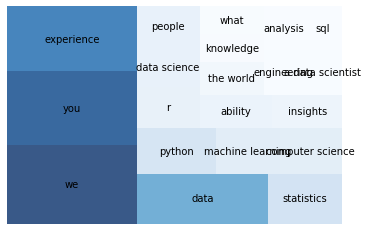

In [198]:
top_words = count(df['chunks'])
top_20 = top_words[top_words['rank'] <= 20]
pct_totals = top_20['pct_total']

cmap = matplotlib.cm.Blues
mini=min(pct_totals)
maxi=max(pct_totals)
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in pct_totals]

squarify.plot(
    sizes=pct_totals,
    label=top_words['word'],
    alpha=.8,
    color=colors
)
plt.axis('off')
plt.show()

## 5) Use Scikit-Learn's tfidfVectorizer to get a TF-IDF feature matrix

In [203]:
# Instantiate vectorizer object.
tfidf = TfidfVectorizer(
    tokenizer=get_chunks, 
    min_df=0.025, 
    max_df=.975,
    stop_words='english'
) # ngram_range=(1,2)

# Create a vocabulary and get word counts per document.
dtm = tfidf.fit_transform(df.job) # Similiar to fit_predict

# Get feature names to use as dataframe column headers.
dtm_df = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())

# View Feature Matrix as DataFrame.
dtm_df.head()

,2 years,2+ years,3+ years,5+ years,a broad range,a company,a data scientist,a degree,a difference,a disability,...,visualization,visualizations,ways,women,work,work experience,years,your career,your skills,your work
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.092967,0.0,0.172566,0.0,...,0.0,0.0,0.0,0.0,0.112367,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.161349,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.490904,0.0,0.0,0.0


## 6) Create a NearestNeighbor Model. Write the description of your ideal datascience job and query your job listings. 

In [205]:
# Instantiate the model.
nn_model  = NearestNeighbors(
    n_neighbors=5,
    algorithm='kd_tree')

# Fit model on TF-IDF Vectors.
nn_model.fit(dtm)

C:\Users\Owen\Anaconda3\envs\nlp1\lib\site-packages\sklearn\neighbors\base.py:217: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "


NearestNeighbors(algorithm='kd_tree', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=None, n_neighbors=5, p=2, radius=1.0)

In [208]:
ideal_job_description = [
    """
    Machine Learning Engineer

$80k – $160k • 0.0% – 1.0%

Apply now

We are looking for a Machine learning scientist to join our Science team and help us scale our ambitious Natural language processing (NLP) and ML (Vision, Speech) efforts to build the best conversational Artificial intelligence.

So far, each time we’ve incorporated new NLP models into the product, we’ve seen significant improvements to both the conversation quality, and the long-term user retention. In particular, our coreference resolution module (NeuralCoref) helped us understand the context in quick exchanges of short text messages measurably better. Our emotion classifier, called TorchMoji (trained on 1.6 billion tweets!) has let us create stronger empathy and more emotional connection to our users.

Your task will be to make our NLP stack and models 10x smarter. You’ll be able to train on our large scale conversation dataset (+100M messages), and you’ll see the output of your work in production, used by real users, in almost real time (we ship NLP models every week).

Along the way, you’ll also publish open source implementations and contribute to the state-of-the-art in academic research in Machine learning. In 2018, our team already got papers accepted in several top conferences in AI/ML happening this year: ACL (current top conference in NLP) and ICLR (founded in 2013 by Yoshua Bengio & Yann Lecun) and we are on track to be featured in several other top AI/ML venues this year.


What You’ll Do

- Design and implement cutting-edge NLP models.
- Working with our engineering and product team, deploy those models in production to our conversation stack, and monitor and analyse their results.
- Along the way, publish some kick-ass research papers to top-tier conferences.

Who You Are

- MSc. or PhD in Computer science, engineering or a related field (Math, Physics, Statistics, …).
- Vision alignment: you believe everyone will talk to an AI everyday in 5 years and you are passionate to work hard to achieve this vision.
- Proficient in Python and at least one ML framework: PyTorch or Tensorflow.
- Familiarity with NLP “deep-learning style”: RNN, CNN, attention-based models, embeddings (the content of Richard Socher’s Stanford class for instance)
- Optional but appreciated:
- Familiar with “classical” NLP tasks and tools: syntactic and semantic parsing, semantic relations extraction (openIE), co-reference resolution
- Knowledge of C/C++ and Carnegie Mellon’s DyNet (a C++ neural net framework) would be appreciated


We want to develop a strong culture of ownership where all team members are top-level builders and doers (no long meetings here!). We’ve done other startups in the past, so we want to always find the intersection between what makes you most excited, and what makes sense for the company.

This is a full time salaried position, including competitive salaries, stock options and health insurance. Location is in Brooklyn, New York.

If not based in NY we can help you relocate.

Location

New York CityParis

Job typeFull-time

Visa sponsorshipAvailable

Experience3+ years
    """
]

In [210]:
# Make description correct format.
ideal_job = tfidf.transform(ideal_job_description)

# Find similar job listings.
nn_model.kneighbors(ideal_job.todense())

(array([[1.        , 1.19610205, 1.20930289, 1.22498067, 1.22504008]]),
 array([[159, 421,  93, 179, 254]], dtype=int64))

In [213]:
# Look at a relevant result.
df.job[254]

"b'Please review the job details below. Are you excited by the possibilities presented by combining machine learning and the cloud? Do you have the drive to contribute to our nation's security? In an increasingly data-rich environment, threats to our country are harder to detect and require the augmentation of intelligence by machines. As a part of our team, you can help turn this complex problem into a real solution for an important Intelligence Community customer. We are looking to hire a cleared Data Scientist to an established team of motivated data scientists to make the customer's vision a reality. What you will be doing: Contributing to the development and maintenance of NGA Maritimes automated machine learning framework housed in AWS and using natural language processing (NLP) Improving an architecture to ingest naval chart or notice data and other location based intelligence data at scale Learning and applying NLP to customer data Assisting NGA in their efforts to migrate the 

## Stretch Goals

 - Try different visualizations for words and frequencies - what story do you want to tell with the data?
 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. How are those distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this. Do a little bit of research to see what might be good for this. Also, remember that algorithms that depend on Euclidean distance break down with high dimensional data.
 - Create a labeled dataset - which jobs will you apply for? Train a model to select the jobs you are most likely to apply for. :) 